In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from skimage import exposure


!pip install opencv-python-headless

**1: HOG (Histogram of Oriented Gradients) Object Detection**

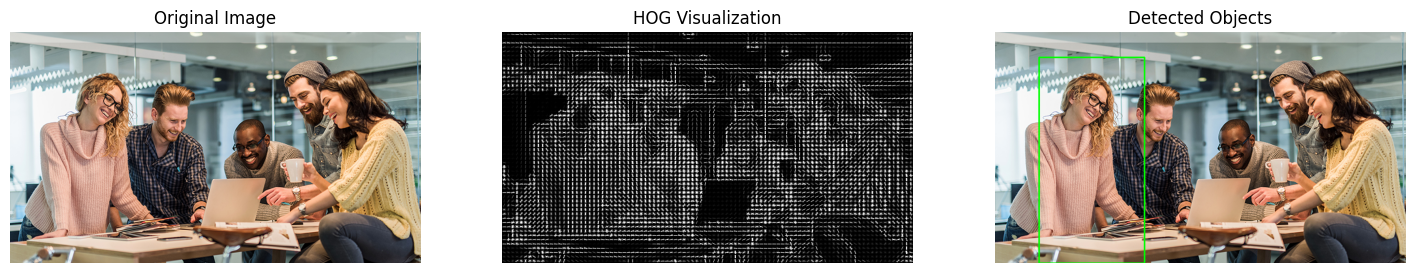

In [ ]:
# Load an image containing a person or an object
image = cv2.imread('sample.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply the HOG descriptor to extract features
features, hog_image = hog(
    gray_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    channel_axis=None
)

# Scale the HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Initialize the HOG descriptor/person detector
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Detect people in the image
(rects, weights) = hog_detector.detectMultiScale(gray_image,
                                                 winStride=(8, 8),
                                                 padding=(8, 8),
                                                 scale=1.05)

# Draw bounding boxes around detected objects
detected_image = image.copy()
for (x, y, w, h) in rects:
    cv2.rectangle(detected_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the images in a 3-column layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(hog_image_rescaled, cmap='gray')
axes[1].set_title('HOG Visualization')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
axes[2].set_title('Detected Objects')
axes[2].axis('off')

plt.show()



**2: YOLO (You Only Look Once) Object Detection**

In [ ]:
# Download YOLOv3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

# Download YOLOv3 config file
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

# Download COCO names (class labels)
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2024-10-30 11:52:24--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  39.8MB/s    in 6.6s    

2024-10-30 11:52:31 (35.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-10-30 11:52:31--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

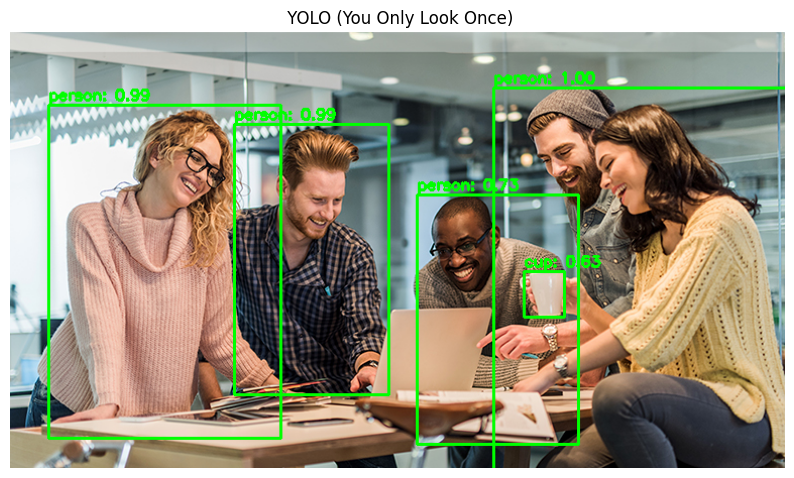

In [ ]:
# Paths to YOLOv3 files
weights_path = "yolov3.weights"
config_path = "yolov3.cfg"
labels_path = "coco.names"

# Load class labels from coco.names
with open(labels_path, 'r') as f:
    labels = f.read().strip().split("\n")

# Load YOLOv3 model using OpenCV's dnn module
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Set preferable backend and target to OpenCV
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def detect_objects(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # Get image dimensions
    (H, W) = image.shape[:2]

    # Create a blob from the image to feed to YOLOv3
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get output layer names for YOLOv3
    layer_names = net.getLayerNames()
    output_layer_names = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

    # Perform forward pass for detection
    detections = net.forward(output_layer_names)

    boxes, confidences, class_ids = [], [], []

    # Loop over each detection
    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Filter out weak detections by confidence threshold
            if confidence > 0.5:
                # Scale bounding box back to image size
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # Append box, confidence, and class ID to respective lists
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maxima Suppression to reduce overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes and labels on the image
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        color = (0, 255, 0)  # Green bounding box for detected object
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the output
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(" YOLO (You Only Look Once)")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Run detection on your specific image
detect_objects("sample.jpg")


**3: SSD (Single Shot MultiBox Detector) with TensorFlow**

In [ ]:
!pip install tensorflow
# Download the SSD MobileNet V2 model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# Extract the downloaded model
!tar -xvzf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# Download the mscoco_label_map.pbtxt file from GitHub
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt


--2024-10-30 13:38:36--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.117.207, 173.194.202.207, 173.194.203.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.117.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2024-10-30 13:38:36 (167 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320

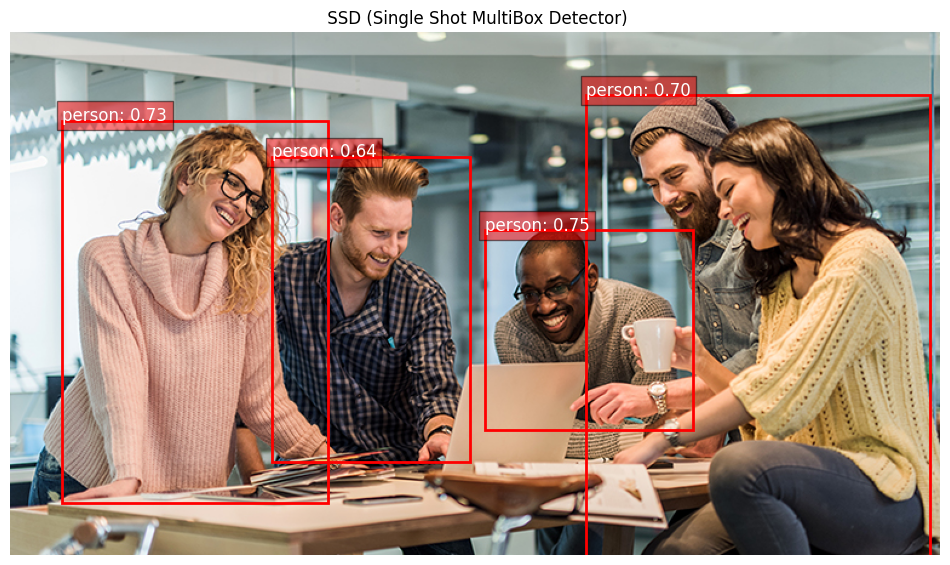

In [ ]:
# Load the label map
def load_label_map(label_map_path):
    category_index = {}
    with open(label_map_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("id:"):
                id_ = int(line.split(": ")[1])
            elif line.startswith("display_name:"):
                display_name = line.split(": ")[1].strip().strip('"')
                category_index[id_] = display_name
    return category_index

# Load the SSD model and label map
model_dir = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model"
label_map_path = "mscoco_label_map.pbtxt"
category_index = load_label_map(label_map_path)

# Load the model
model = tf.saved_model.load(model_dir)

# Load and preprocess the image
def load_image_into_numpy_array(path):
    return np.array(cv2.imread(path))

image_path = "sample.jpg"
image_np = load_image_into_numpy_array(image_path)

# Detect objects
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = model(input_tensor)

# Process detection results
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# Convert the detection classes to integer
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# Filter out boxes with low confidence
confidence_threshold = 0.5
boxes = detections['detection_boxes'][detections['detection_scores'] > confidence_threshold]
classes = detections['detection_classes'][detections['detection_scores'] > confidence_threshold]
scores = detections['detection_scores'][detections['detection_scores'] > confidence_threshold]

# Visualize results
plt.figure(figsize=(12, 8))
plt.title(" SSD (Single Shot MultiBox Detector)")
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

# Draw bounding boxes
for box, cls, score in zip(boxes, classes, scores):
    (ymin, xmin, ymax, xmax) = box
    plt.gca().add_patch(plt.Rectangle((xmin * image_np.shape[1], ymin * image_np.shape[0]),
                                        (xmax - xmin) * image_np.shape[1],
                                        (ymax - ymin) * image_np.shape[0],
                                        fill=False, color='red', linewidth=2))
    plt.text(xmin * image_np.shape[1], ymin * image_np.shape[0],
             f"{category_index[cls]}: {score:.2f}", color='white', fontsize=12,
             bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()


**4: Traditional vs. Deep Learning Object Detection Comparison**

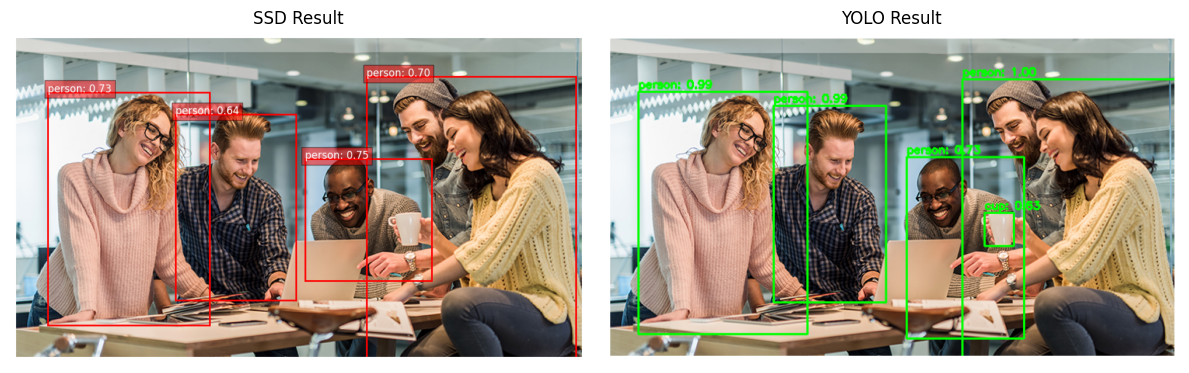

In [ ]:
# Function to display images
def display_images(ssd_image, yolo_image, ssd_title='SSD Result', yolo_title='YOLO Result'):
    plt.figure(figsize=(12, 6))

    # Check if SSD image is loaded
    if ssd_image is not None:
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(ssd_image, cv2.COLOR_BGR2RGB))
        plt.title(ssd_title)
        plt.axis('off')
    else:
        print("Error: SSD image not loaded.")

    # Check if YOLO image is loaded
    if yolo_image is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(yolo_image, cv2.COLOR_BGR2RGB))
        plt.title(yolo_title)
        plt.axis('off')
    else:
        print("Error: YOLO image not loaded.")

    plt.tight_layout()
    plt.show()

# Example images with bounding boxes
ssd_image = cv2.imread('ssd_result.jpg')
yolo_image = cv2.imread('yolo_result.jpg')


display_images(ssd_image, yolo_image)
